In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community
import csv as csv
import seaborn as sns
import collections
import matplotlib.pyplot as plt
import copy
import igraph as ig
from igraph import Graph
from collections import Counter




# Introduction

Bitcoin is a decentralized peer-to-peer cryptocurrency based on the blockchain technology developed by the mysterious [Satoshi Nakamoto](https://bitcoin.org/bitcoin.pdf). This cryptocurrency revealed itself to be an alternative for governmental currency free from centralized bank. The security of the Bitcoin transaction network is based from its decentralization and the fact that its robustness comes from the participation of every actors of the network. If in 2009, when the network was launched, this cryptocurrency was only a dream for anarchists and "nerds", this turn in less than 5 years in a strong digital asset. This led it to be considered as a good store of value, a "digital gold". But if a lot of use-cases are developed day to day, it is now mainly an object of speculation, whith strong price fluctuations. 

We are going to explore the data from Bitcoin transactions during three days in september 2016. Then, we are going to try if we can associate price fluctuations to change in network topology.

## General network topology.

First, we need to import the data and clean it. The first cleaning process is to proceed to "user contraction". Indeed, in [a series of papers studying Bitcoin transaction networks,](https://senseable2015-6.mit.edu/bitcoin/) the authors fusion users that participate in the same transaction input. The second cleaning process is just to remove self-loops or 0 btc transactions. Also, I change the shape of the data so it is more convenient for me to use.

In [2]:
def user_contraction(data): #Assemble les adresses en utilisateurs, si ces adresses sont utilisées dans le même tx_in.
    user_address = dict() #Création des dictionnaires user-> address et address -> user
    address_user = dict()
    u_id = 0 #les users sont nommées 0,1,2...
    
    for line in data['tx_ins']: 
        #print(line)
        user_key = 0
        
        #Pour chaque transaction, on rassemble les adresses du tx_in dans une liste
        address_list = [entry['address'] for entry in line]
        #print(address_list)
        
        found = 0
        for address in address_list:
            if address in address_user.keys(): #On regarde si l'une des adresses a déjà été référencée
                found = 1
                #print('found')
                user_key = address_user[address] #Si c'est le cas, on récupère l'ID
                break
        #print('hey')
        if found == 1:
    #On assigne le même ID à chacune des adresses et on les rassemble dans la même entrée
            for address in address_list:
                if address not in user_address[user_key]:
                    address_user[address] = user_key
                    user_address[user_key].append(address)
    #Si aucune adresse n'avait été  déjà référencée, on créé une nouvel ID et on rassemble toutes les adresses sous cet ID
        else:
            user_address[u_id] = []
            for address in address_list:
                    user_address[u_id].append(address)
                    address_user[address] = u_id
            u_id += 1
                
    return user_address, address_user

def data_clean(data, a_u): #Transforme les données en une forme facilement convertissable en Edges
                           #Prend en entrée les données "brutes" et un dictionnaire adresse -> user mapping
        col = ['rate','time','u_in','u_out','val'] #Nom des colonnes: rate: taux d'échange, time: date,  
                                                    # 'u_in' et 'u_out' emmeteur, destinataire et 'val': valeur en USD
        liste = [] #on met toutes les entrées dans une liste avant d'en faire un data frame
        
        #On récupère les données pour chaque ligne
        for index, line in data.iterrows():
            
            rate = line['exchange_rate']
            time = line['timestamp']

            u_in = line['tx_ins'][0]['address']
            u_in = a_u[u_in]
                
            for i in range(len(line['tx_outs'])): #On vérifie si l'une des adresses destinatrices sont connues ou pas
                u_out = line['tx_outs'][i]['address']
                
                if u_out in a_u.keys():
                    u_out = a_u[u_out]
                    
                val = line['tx_outs'][i]['value']
                val = val/(1e8) * rate
                
            #Ici on peut rajouter pleins de conditions, exemple si on ne veut pas garder 
            #les transactions dont la valeur est inférieure à une certaine somme
                if u_in != u_out and val != 0:
                    liste.append([rate,time,u_in,u_out,val])
                
            
        data2 = pd.DataFrame(liste,columns=col)
        return data2
    
def make_digraph(clean_data): #transforme les data en diGraph où edge est la somme des transactions
    G = nx.DiGraph()
    
    for i,l in clean_data.iterrows():
        #print(l)
        u = l['u_in']
        v = l['u_out']
        s = l['val']
        #t = l['time']

        if (u,v) not in G.edges():
            G.add_weighted_edges_from([(u,v,s)])
        else:
            previous_sum = G.get_edge_data(u,v)
            previous_sum = previous_sum['weight']
            s += previous_sum
            G.add_weighted_edges_from([(u,v,s)])
            
        
    return G


def graph_clean(G): #
    
    print('Nettoyage du graph')
    nG = nx.DiGraph()
    kept_edges = []
    for edge in list(G.edges):
        u = edge[0]
        v = edge[1]
        s = G.get_edge_data(u,v)
        s = s['weight']
        if(s > 0 and u!=v):
            kept_edges.append((u,v,s))
    
    nG.add_weighted_edges_from(kept_edges)
    print(len(list(nG.nodes)), ' nodes and ',len(list(nG.edges)), 'edges.')
    
    return nG

In [ ]:
file = 'C://Users//Admin//Documents//cours//complex networks//bitcoin'
data = pd.read_json(file, lines = True )

u_a, a_u = user_contraction(data)
clean_data = data_clean(data, a_u)
G = make_digraph(clean_data)

nG = graph_clean(G) #I don't remember why I did this because it doesn't seem to change much, but still I put it in the notebook.


In [57]:
pickle_test = pd.read_pickle('C://Users//Admin//Documents//cours//complex networks//pickle_clean_data')
G = make_digraph(pickle_test)
nG = graph_clean(G)

Nettoyage du graph
817680  nodes and  1273486 edges.


Now we have our graph, we'll do a brief overview to know how to reduce more the dataset which is not usable on gephi yet (817680 nodes and 1273486 edges right now).

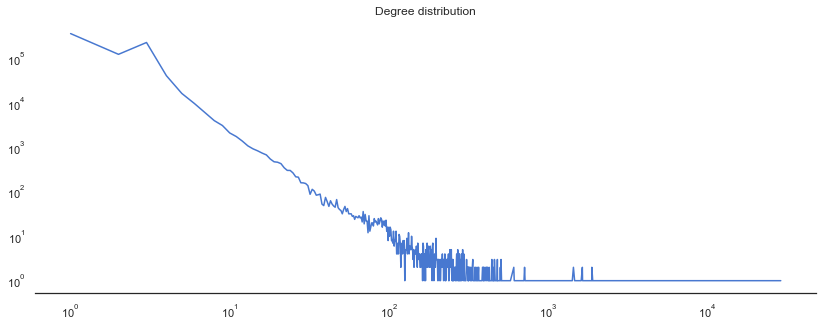

In [70]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(14, 5), sharex=True)

sns.despine(left=True)

#Degree distribution.
axes.set_title('Degree distribution')
axes.set_xscale('log')
axes.set_yscale('log')
degrees = [nG.degree(n) for n in nG.nodes()]
c = Counter(degrees)
x = list(c.keys())
y = list(c.values())
sns.lineplot(x=x, y=y, color="b",ax=axes)

plt.show()

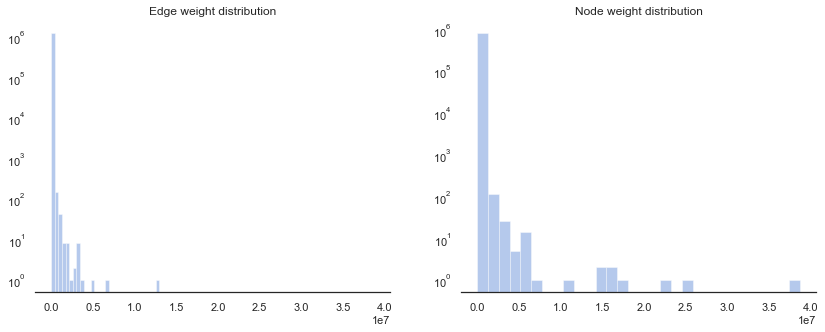

In [71]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.despine(left=True)



#Edge weight distribution.
axes[0].set_xscale('linear')
axes[0].set_yscale('log')
axes[0].set_title('Edge weight distribution')
e_weights = np.array([e[2]['weight'] for e in nG.edges(data=True)])
#c = Counter(e_weights)
#x = list(c.keys())
#y = list(c.values())
sns.distplot(e_weights, kde=False, bins=30, color="b",ax=axes[0])


#Node weight distribution.
#c = Counter(e_weights)
#x = list(c.keys())
#y = list(c.values())
axes[1].set_title('Node weight distribution')
axes[1].set_xscale('linear')
axes[1].set_yscale('log')
n_weights = np.array([nG.degree(n,weight='weight') for n in nG.nodes()])
sns.distplot(n_weights, kde=False, bins=30, color="b",ax=axes[1])

plt.show()



    


We can see that we can get a powerlaw distribution for the degree distribution, which is caracteristic of "real" networks. However, the loglog scale does not give anything relevant for edge weight and node weight distribution so I only plotted it with the log y scale. Interestingly, we have a little group of highly connected and "heavy" nodes. Let's investigate it.

94733 degree: 28729  weight= 11703.351758046094 indegree = 326  indegree weight= 3683.0064623936996 outdegree= 28403 outdegree weight= 8020.345295652393 net= -4337.338833258694


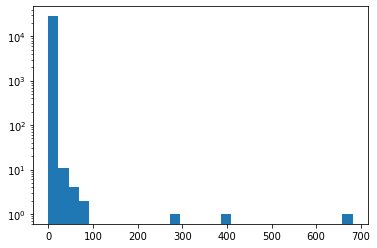

PRESS ENTER TO CONTINUE.
367573 degree: 29054  weight= 6924.22796030041 indegree = 1  indegree weight= 3653.5199999999995 outdegree= 29053 outdegree weight= 3270.7079603004104 net= 382.81203969958915


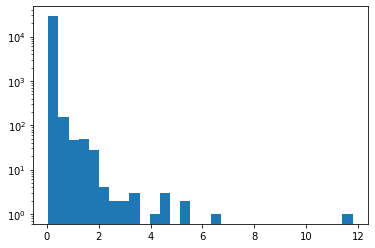

PRESS ENTER TO CONTINUE.


In [23]:
#Selecting nodes with degree above and ploting the weight distribution of their edges.
biggy = [n for n in nG.nodes() if nG.degree(n)>20000]
for big in biggy:
    #This line prints different statistics relevant to the selectionned node.
    print(big, 'degree:',nG.degree(big),' weight=',nG.degree(big, weight='weight'), 'indegree =', nG.in_degree(big), ' indegree weight=',nG.in_degree(big,weight='weight'),'outdegree=', nG.out_degree(big), 'outdegree weight=', nG.out_degree(big,weight='weight'), 'net=',(nG.in_degree(big,weight='weight')-nG.out_degree(big,weight='weight')))
    edge_list = list(nG.edges(nbunch = big, data='weight', default=1))
    weights = [e[2] for e in edge_list]
    plt.hist(weights, bins=30)
    plt.yscale('log')
    plt.show()
    wait = input("PRESS ENTER TO CONTINUE.")
    


Unexpectedly, these nodes with a high degree do not have a high total weight, maybe they are bots spamming the market with very small transactions. Let's fish for the nodes that have a very high weight now.

2753 degree: 804  weight= 38733073.92533308 indegree = 187  indegree weight= 20735128.646600798 outdegree= 617 outdegree weight= 17997945.27873229
net= 2737183.367868509


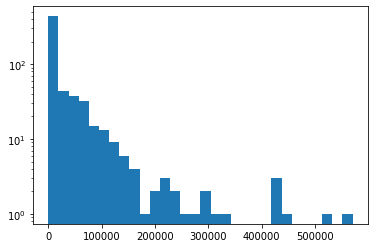

All edges


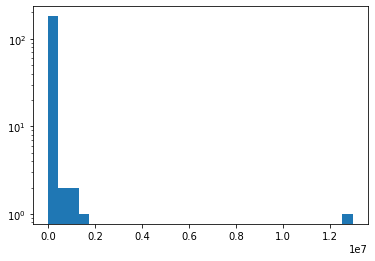

Entering transactions.


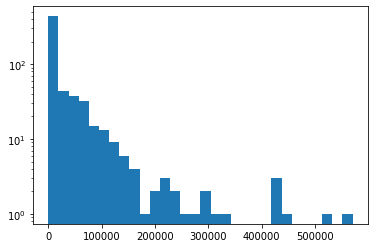

Leaving transactions.


In [24]:
#Selecting nodes with total weight above 3*1e7 dollars.
biggy = [n for n in nG.nodes() if nG.degree(n, weight='weight')>3*1e7]
for big in biggy:
    print(big, 'degree:',nG.degree(big),' weight=',nG.degree(big, weight='weight'), 'indegree =', nG.in_degree(big), ' indegree weight=',nG.in_degree(big,weight='weight'),'outdegree=', nG.out_degree(big), 'outdegree weight=', nG.out_degree(big,weight='weight'))
    print('net=',(nG.in_degree(big,weight='weight')-nG.out_degree(big,weight='weight')))
    edge_list = list(nG.edges(nbunch = big, data='weight', default=1))
    weights = [e[2] for e in edge_list]
    plt.hist(weights, bins=30)
    plt.yscale('log')
    plt.show()
    wait = input("All edges")
    edge_list = list(nG.in_edges(nbunch = big, data='weight', default=1))
    weights = [e[2] for e in edge_list]
    plt.hist(weights, bins=30)
    plt.yscale('log')
    plt.show()
    wait = input("Entering transactions.")
    edge_list = list(nG.out_edges(nbunch = big, data='weight', default=1))
    weights = [e[2] for e in edge_list]
    plt.hist(weights, bins=30)
    plt.yscale('log')
    plt.show()
    wait = input("Leaving transactions.")
    
    

Wow! That guy is interesting! This is the blue whale of the network. During the three days, he made a "net" benefit of almost 3M$. Well, we don't know if he actually made any transactions on an exchange so maybe he did not have an influence on the price. It would be interesting to see with who he did these big transactions, and when they happened relatively to price evolution to check for any influences. But we're not here to investigate on a single person but rather for a network view, so we'll go back to that guy if we get the time to do it. 

Now, the issue we have is that the network is wayyy too big to be looked at in Gephi. So, I could clean the data by removing/fusioning some nodes depending on its properties, but I don't want to make an arbitrary choice. So my idea now is to use an algorithm for community detection and then to fusion these communities in single nodes.

First, I'm going to extract the weakly connected component of the network in order to leave out any nodes that does not significantly participates to the main network.

In [5]:
weak_size_distribution=[len(g) for g in sorted(nx.weakly_connected_component_subgraphs(nG), key=len)]
print('The maximum weakly connected components contains :', max(weak_size_distribution),'nodes.')
print('Extracting that subgraph...')
G = max(nx.weakly_connected_component_subgraphs(nG), key=len)
print('Component extracted!')
print('This connected components contains: ',len(list(G.nodes)), ' nodes and ',len(list(G.edges)),' edges.')

The maximum weakly connected components contains : 770926 edges.
Extracting that subgraph...
Component extracted!
This connected components contains:  770926  nodes and  1240335  edges.


In [ ]:
#Let's convert to an IGraph, which possess an Infomap method for community detection
#Indeed, NetworkX only contains community detection algorithms for undirected graphs
nx.write_graphml(G,'graph.graphml') # Export NX graph to file
Gix = ig.read('graph.graphml',format="graphml") # Create new IG graph from file
label_prog= Gix.community_label_propagation(weights='weight')


OK, sadly, the graph did not lose much nodes or edges (if any...) and it will still be impossible to use Gephi. I tried to compute modularity using IGraph and label propagation ([the most scalable community detection algorithm according to Yhan et al. 2016](https://www.nature.com/articles/srep30750)), but on my 3rd gen i5 CPU it was still running after 2h... But thanks to Francois Gu and his 9th gen i7 CPU, I had my modularity classes in less than 5 min. He used the modularity algorithm of Gephi, which is based on Louvain. I'll now proceed to fusion my community in single nodes.

In [ ]:
#Just pickling the networkx graph in order to load it easily if I need it.
mG = nx.read_graphml('C://Users//Admin//Documents//cours//complex networks//yo.graphml')
write.gpickle(mG,'C://Users//Admin//Documents//cours//complex networks//modGraph.pickle')


In [91]:
imod = ig.read('C://Users//Admin//Documents//cours//complex networks//yo.graphml',format="graphml")

ig.summary(imod)
print("Dictionnary creation")
mod_nodes = {}
#Add modularity keys to dictionaries
i = 0
for mod in imod.vs['Modularity Class']:
    if mod not in mod_nodes.keys():
        mod_nodes[mod] = i
        i +=1
print(i)
adj = np.zeros((i,i))
        
#Fill the dictionaries
print('Filling the adjencacy matrix')
i = 0
for edge in imod.get_edgelist():
    
    mod_u = imod.vs['Modularity Class'][edge[0]]
    mod_v = imod.vs['Modularity Class'][edge[1]]
    u = mod_nodes[mod_u]
    v = mod_nodes[mod_v]
    w = imod.es['weight'][i] 
    
    adj[u,v] += w
    i+=1
    

IGRAPH D-W- 770926 1240335 -- 
+ attr: Modularity Class (v), id (v), label (v), id (e), weight (e)
Dictionnary creation
684
Filling the adjency matrix


Finally! After letting this run overnight (I have to admit that the algo wasn't really opti) I had my adjacency matrix! Phew! Now the graph will be way easier to handle. Let's look at it in Gephi.

In [55]:
#Just garbage cell here to hande and save my data.
def csv_writer(G, filename):
    csvtext = [['Source','Target','Sum']]
    for e in list(G.edges):
        u = e[0]
        v = e[1]
        w = G.get_edge_data(u,v)
        w = w['weight']
        csvtext.append([str(u),str(v),str(w)])
    
    with open(filename, 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(csvtext)
        
    csvFile.close()


#np.save('C://Users//Admin//Documents//cours//complex networks//array.npy',adj)
#ModG = nx.from_numpy_array(adj,create_using=nx.DiGraph)
#csv_writer(ModG,'C://Users//Admin//Documents//cours//complex networks//ModGraph.csv' )

![](img/ABCD.png)

OK, this is a big mess but also there are some intersting things to see here(**[A]**). Just to remember here, **each node is a community** with supposedly more exchanges inside a community than with the rest of the network. The layout algorithm is Force Atlas 2 with default parameters and this gave the best results. I also reran Louvain algorithm in order to give some substance to the graph but I do not pretend that all the communities displayed here are significant. The size of the nodes represents the total weighted degree of the node.
So, what do we see? The network looks kind of like an octopus. The central body is highly interconnected as we can see it forms a single strongly component in **[B]**. Then, satelites communities gravitate around that main network.  What gathers these communities under the same community flag is that they use the same hub as a gate to connect to the main body **([C])**. In Figure **[C]**, I've put these hubs in evidence through PageRank. Other indices yielded the same results. PageRank calculates node's importance through how much they are connected to other high degree nodes. It is more suitable to my graph than eigenvectory centrality, because the latter is not the best for weighted directed networks. It is interesting to see that other nodes in the main body seems to have a high importance. Indeed, running other algorithms like HITS for hub's detection gives a higher score to other nodes in the core. Thus, the core is constituted of highly interconnected communities with a subset being seeing more bitcoin going through itselves. The three bottom left have a higher score probably because they display this strong "gate" pattern and they are connected to each others. Finally, as we can see in figure **[D]**, all nodes are connected to each other as they have all roughly the same closeness centrality score. Once again, we can see the importance of some of these nodes through their slightly higher scores. This closeness is reflected in the diameter which is of 7.
Now, interpreting this graph is hard because we don't have any information on the nature of the nodes(/communities) observed here. In 2016, most of the transactions are thought to be from [gambling, illegal transactions and market speculation](https://www.aeaweb.org/articles?id=10.1257/jep.29.2.213). It is also an [alternative currency for countries where the local currency lost its value](https://qz.com/africa/1021155/bitcoin-is-being-taken-up-in-zimbabwe-nigeria-south-africa-and-venezuela-among-developing-countries/). Satellites nodes could be individual users who own several adresses. They could be one-time users or one-platform users that only send money to gambling website or market exchanges. Best candidates for the hubs are exchange platforms like Coinbase or Bittrex. Indeed, these platforms receive a lot of bitcoin from trading users, but also send a lot of them to people who want to take their money off the platform and thus secure their funds. The issue with understanding who is who and does what is that I can't differentiate between nodes that represent users with several adresses and actual communities. Thus, the so-called hubs might just be communities exchanging money on the same platform on Coinbase or SilkRoad. However, [Cazabet et al. 2017](https://link.springer.com/chapter/10.1007/978-3-319-72150-7_14) suggest that the method I used should approximately yield for each node being actually a user. Finally, [Juhasz et al. 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0207000) provide a method allowing to track user's geographical location through Bayesian inferance, which thus could help to interpret such graphs.


### Time varying structure

OK, now we have studied the general structure of the Bitcoin transaction network, let's see how it evolves over time. We'll look at the the graph structure at three points in time: before the price rise, during, and after.

In [3]:
#Reloading the data to recover the original dataset
file = 'C://Users//Admin//Documents//cours//complex networks//bitcoin'
data = pd.read_json(file, lines = True )

u_a, a_u = user_contraction(data)
clean_data = data_clean(data, a_u)




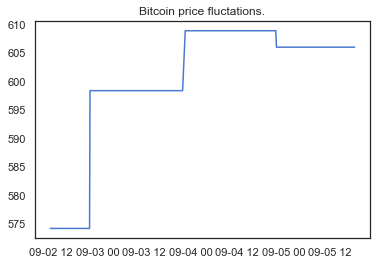

In [77]:
x = list(clean_data['time'])
y = list(clean_data['rate'])
plt.plot(x,y)
plt.title('Bitcoin price fluctations.')
plt.show()

As we can see on this plot, at the end of September the 2nd, 2016, a strong price rise happened from 575$ to almost 590$. Can we see the change of network topology after the price rise? Or, most interestingly, can we see the network topology change **before** the price rise, which would mean some actors (potential 'market manipulator') are placing themselves in order to profit a maximum from that rise?

In [14]:
def make_digraph_time(clean_data): #Same function as earlier but now keeping track of time
    G = nx.DiGraph()
    start = str(min(clean_data['time']))
    end = str(max(clean_data['time']))
    for i,l in clean_data.iterrows():
    
        u = l['u_in']
        v = l['u_out']
        s = l['val']
        

        if (u,v) not in G.edges():
            G.add_edges_from([(u,v,{'weight':s, 'start':start, 'end':end})])
        else:
            previous_sum = G.get_edge_data(u,v)
            previous_sum = previous_sum['weight']
            s += previous_sum
            G.add_edges_from([(u,v, {'weight':s, 'start':start, 'end':end})])
            
    return G

def csv_writer_time(liste_G, filename):
    csvtext = [['source','target','weight','start date', 'end date']]
    i = 1
    for G in liste_G:
        message = 'Writing sample {}!'.format(i)
        print(message)
        i+=1
        for e in list(G.edges(data=True)):
            u = e[0]
            v = e[1]
            data = e[2]
            w = data['weight']
            start = data['start']
            end = data['end'] 
            csvtext.append([str(u),str(v),str(w),str(start),str(end)])
    
    print('Transferring to csv file.')
    with open(filename, 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(csvtext)
        
    csvFile.close()

In [15]:
#Creating 7 graphs at different time points, before and after the price rise.
print('Sampling...')
sample1 = clean_data.loc[(clean_data['time'] >= "2016-09-02 12:00:00") & (clean_data['time'] < "2016-09-02 14:00:00")]
sample2 = clean_data.loc[(clean_data['time'] >= "2016-09-02 18:00:00") & (clean_data['time'] < "2016-09-02 20:00:00")]
sample3 = clean_data.loc[(clean_data['time'] >= "2016-09-02 22:00:00") & (clean_data['time'] < "2016-09-03 00:00:00")]
sample4 = clean_data.loc[(clean_data['time'] >= "2016-09-03 02:00:00") & (clean_data['time'] < "2016-09-03 04:00:00")]
sample5 = clean_data.loc[(clean_data['time'] >= "2016-09-03 06:00:00") & (clean_data['time'] < "2016-09-03 08:00:00")]
sample6 = clean_data.loc[(clean_data['time'] >= "2016-09-03 10:00:00") & (clean_data['time'] < "2016-09-03 12:00:00")]
sample7 = clean_data.loc[(clean_data['time'] >= "2016-09-03 14:00:00") & (clean_data['time'] < "2016-09-03 16:00:00")]

print('Sampling over...')
print('Converting towards DiGraph...')
tG1 = make_digraph_time(sample1)
print('Sample 1 converted!')

tG2 = make_digraph_time(sample2)
print('Sample 2 converted!')

tG3 = make_digraph_time(sample3)
print('Sample 3 converted!')

tG4 = make_digraph_time(sample4)
print('Sample 4 converted!')

tG5 = make_digraph_time(sample5)
print('Sample 5 converted!')

tG6 = make_digraph_time(sample6)
print('Sample 6 converted!')

tG7 = make_digraph_time(sample7)
print('Sample 7 converted!')

liste_sample = [tG1,tG2,tG3,tG4,tG5,tG6,tG7]

print('Writing towards CSV files')
csv_writer_time(liste_sample,'timegraph.csv')


Sampling...
Sampling over...
Converting towards DiGraph...
Sample 1 converted!
Sample 2 converted!
Sample 3 converted!
Sample 4 converted!
Sample 5 converted!
Sample 6 converted!
Sample 7 converted!
Writing towards CSV files
Writing sample 1!
Writing sample 2!
Writing sample 3!
Writing sample 4!
Writing sample 5!
Writing sample 6!
Writing sample 7!
Transferring to csv file.


Now, as I did not manage to use dynamical graphs in Gephi, I just made a community detection and then exported the graph. This way, I can fusion the nodes into single communities for each graph and then re-export into Gephi and compare how communities evolve. This is a lot of back-and-forth but this is the best I came up in this time.

In [52]:
#time_graph = nx.read_graphml('timegraph_com.graphml')


#Création de la liste de noeuds
print('Création de la liste de noeuds')
nodes = list(time_graph.nodes(data=True))

#On créé un dictionnaire noeud -> community class
print('Création du dictionnaire de communautés')
node_com = {}
for n in nodes:
    com = n[1]['Modularity Class']
    node_com[n[0]]=com


#On créé un dictionnaire (com1,com2): poids, pour chaque graph
tg1 = {}
tg2 = {}
tg3 = {}
tg4 = {}
tg5 = {}
tg6 = {}
tg7 = {}

#Dictionnaire rassemblant tous les dictionnaires, ce qui permet de les retrouver depuis leur date de départ
dico_graph = {'2016-09-02 12:05:02':tg1, '2016-09-02 18:00:29':tg2, '2016-09-02 22:06:01':tg3, '2016-09-03 02:13:46':tg4, '2016-09-03 06:45:03':tg5, '2016-09-03 10:25:09':tg6, '2016-09-03 14:12:24':tg7}

#Classe chacun des edges dans le dictionnaire correspondant, en prenant le soin de fusionner les noeuds en communautés
print('Fusion des communautés en cours...')
for e in list(time_graph.edges(data=True)):
    u = node_com[e[0]] 
    v = node_com[e[1]]
    data = e[2]
    w = data['weight']
    start = data['start date']
    
    if((u,v) not in dico_graph[start].keys()):
        dico_graph[start][(u,v)] = w
    else:
        dico_graph[start][(u,v)] = dico_graph[start][(u,v)] + w


    
        
print('Terminé!')

    
  
        

Création de la liste de noeuds
Création du dictionnaire de communautés
Fusion des communautés en cours...
Terminé!
1838
1841
1030
1393
1017
1207
1877


OK, now let's remake 7 CSV files that I will be able to compare in Gephi.

In [56]:
def dic_to_graph(dic):
    G = nx.DiGraph()
    liste_edges = []
    for e in dic.keys():
        u = e[0]
        v = e[1]
        w = dic[e]
        liste_edges.append((u,v,{'weight':w}))
    G.add_edges_from(liste_edges)
    return G

fin1 = dic_to_graph(tg1)
fin2 = dic_to_graph(tg2)
fin3 = dic_to_graph(tg3)
fin4 = dic_to_graph(tg4)
fin5 = dic_to_graph(tg5)
fin6 = dic_to_graph(tg6)
fin7 = dic_to_graph(tg7)

filename = ['fin1.csv','fin2.csv','fin3.csv','fin4.csv','fin5.csv','fin6.csv','fin7.csv']
graphs = [fin1,fin2,fin3,fin4,fin5,fin6,fin7]
for i in range(7):
    csv_writer(graphs[i],filename[i])

![](img\time.png)

Sadly, this did not work out as I expected. As you can see here, the graph is not connected at all. This example is the first sample but this gives the same thing for other samples. 


# Conclusion

The Bitcoin transaction dataset is one of these really heavy dataset ("Big Data" some people say) that is hard to handle with few computing power. This led me to use technics to reduce it in order to make it observable through Gephi. As we have seen, this network harbors the same caracteristics as "real-life" network which is namely a power-law degree distribution. We've been able to see that the Bitcoin transaction networks has an interesting organization with a main body which is highly connected and has a small diameter. Smaller communities gravitate around the main body and use particularly big hubs that act as gates in order to reach the main body. However the main difficulty with this approach is that we can't properly interpret the network as we do not now the identities of theses nodes/communities.
Finally, the most interesting thing would have been to observe network topology changes during strong price changes, but technical issues made me lost a lot of time and I could not get the result I expected. Maybe a better approach would be to not fusion nodes prior to temporal observation, but my laptop could not handle this kind of tasks.

### Thanks for reading  I hope you found it interesting.
